# Nurses Assignment Problem (NURSES)


In this guide, we’ll explore the Nurses Assignment Problem (NURSES). The NURSES problem involves managing the assignment of nurses to shifts in a hospital.
Nurses must be assigned to hospital shifts in accordance with various staffing constraints.

The goal of the model is to find an efficient balance between the different objectives:

* Minimize the overall cost of the plan and
* Assign shifts as fairly as possible.

The problem's algebraic representation typically takes the following format:

### Indices:

- $n$, $nn$ ; nurses
- $s$, $ss$ ; shifts
- $p_{n,n}$ ; Pair of nurses that prefer to work together
- $i_{n,n}$ ; Pair of nurses that do not get along together
- $v_{n,s}$ ; Vacations of nurses
- $c_{s,s}$ ; Conflicting shifts

### Given Data:

- $d_s$ ; Duration of the shift $s$ in hours
- $req_s$ ; Minimum required number of nurses in shift $s$
- $r_n$ ; Pay rate for nurse $n$
- $mt$ ; Maximum weekly hours a nurse can work -> 40

### Decision Variables:

- $X_{n,s}$ ; Assignment of nurses $n$ to shifts $s$ where $X_{n,s} \in \{0, 1\}$   $\forall n,s$
- $Y_n$ ; Total working time of each nurse $n$ where $Y_n \ge 0$   $\forall n$
- $Salary$ ; Total salaries spent

### Constraints:

- Eliminate conflicting shifts ${n,c_{s,ss}}$: $X_{n,s} + X_{n,ss} \le 1$
- vacations ${v_{n,s}}$: $X_{n,s} = 0$
- preferences ${p_{n,nn}, s}$: $X_{n,s} = X_{nn,s}$
- incompatibilities ${i_{n,nn}, s}$: $X_{n,s} + X_{nn,s} \le 1$
- working_time ${n}$: $Y_n = \sum_s(X_{n,s} \cdot d_s)$
- max_working_time ${n}$: $Y_n \le mt$
- min_required_nurses ${s}$: $\sum_n(X_{n,s}) \ge req_s$
- total_salary: Minimize $salary = \sum_n(r_n \cdot Y_n)$

## Installing required packages

In [1]:
! pip install gamspy openpyxl --upgrade -q

## Importing Modules
The `gamspy` Python package is loaded in order to access GAMSPy syntax.

In [2]:
from gamspy import Container, Set, Alias, Parameter, Variable, Equation, Model, Sum
import pandas as pd

## Read Data

In [3]:
nurse_xls_file = pd.ExcelFile("nurses_data.xlsx")

df_shifts = nurse_xls_file.parse("Shifts")
# Rename df_shifts index
df_shifts.index.name = "shiftId"

# Index is column 0: name
df_nurses = nurse_xls_file.parse("Nurses", header=0, index_col=0)
df_vacations = nurse_xls_file.parse("NurseVacations")
df_associations = nurse_xls_file.parse("NurseAssociations")
df_incompatibilities = nurse_xls_file.parse("NurseIncompatibilities")

# Display the nurses dataframe
print("#nurses = {}".format(len(df_nurses)))
print("#shifts = {}".format(len(df_shifts)))

#nurses = 32
#shifts = 42


## Data preprocessing

1. Add an extra column `dow` (day of week) which converts the string "day" into an integer in 0..6 (Monday is 0, Sunday is 6).

In [4]:
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
day_of_weeks = dict(zip(days, range(7)))


# utility to convert a day string e.g. "Monday" to an integer in 0
def day_to_day_of_week(day):
    return day_of_weeks[day.strip().lower()]


df_shifts["dow"] = df_shifts.day.apply(day_to_day_of_week)

2. Compute the absolute start and end times of each shift.

In [5]:
# an auxiliary function to calculate absolute end time of a shift
def calculate_absolute_endtime(start, end, dow):
    return 24 * dow + end + (24 if start >= end else 0)


df_shifts["wstart"] = df_shifts.start_time + 24 * df_shifts.dow

df_shifts["wend"] = df_shifts.apply(
    lambda row: calculate_absolute_endtime(row.start_time, row.end_time, row.dow),
    axis=1,
)

3. Compute the duration of each shift.

In [6]:
df_shifts["duration"] = df_shifts.wend - df_shifts.wstart

df_shifts.head()

,department,day,start_time,end_time,min_req,max_req,dow,wstart,wend,duration
shiftId,,,,,,,,,,
0,Emergency,Monday,2,8,3,5,0,2,8,6
1,Emergency,Monday,8,12,4,7,0,8,12,4
2,Emergency,Monday,12,18,2,5,0,12,18,6
3,Emergency,Monday,18,2,3,7,0,18,26,8
4,Consultation,Monday,8,12,10,13,0,8,12,4


In [7]:
df_vacations["dow"] = df_vacations.day.apply(day_to_day_of_week)

nurse_vacations = df_vacations.merge(df_shifts.reset_index()[["dow", "shiftId"]])[
    ["nurse", "shiftId"]
]
nurse_vacations.head()

,nurse,shiftId
0,Anne,29
1,Anne,30
2,Anne,31
3,Anne,32
4,Anne,33


In [8]:
proc_shifts = (
    df_shifts[["wstart", "wend"]]
    .sort_values(["wstart"])
    .reset_index()[["shiftId", "wstart", "wend"]]
)


conflicting_shifts = []


cnt = 0


for row in proc_shifts.itertuples():

    for row2 in proc_shifts.iloc[row[0] + 1 :].itertuples():

        if row.wend > row2.wstart:

            conflicting_shifts.append((row.shiftId, row2.shiftId))



conflicting_shifts

[(1, 6),
 (1, 4),
 (6, 4),
 (5, 2),
 (5, 7),
 (2, 7),
 (9, 14),
 (9, 12),
 (14, 12),
 (13, 10),
 (13, 15),
 (10, 15),
 (11, 16),
 (18, 21),
 (19, 22),
 (24, 27),
 (25, 28),
 (30, 33),
 (31, 34),
 (38, 41)]

In [9]:
# Define shift ids and nurse names
shifts_id = df_shifts.index
nurses_names = df_nurses.index

## Model

In [10]:
# Define container
m = Container()

In [11]:
# Sets
n = Set(m, name="n", records=nurses_names, description="Nurses")
s = Set(m, name="s", records=shifts_id, description="Shifts")

nn = Alias(m, "nn", n)
ss = Alias(m, "ss", s)

p = Set(
    m,
    name="p",
    domain=[n, n],
    records=df_associations,
    description="Pair of nurses that prefer to work together",
)
i = Set(
    m,
    name="i",
    domain=[n, n],
    records=df_incompatibilities,
    description="Pair of nurses that dont get along together",
)
v = Set(
    m,
    name="v",
    domain=[n, s],
    records=nurse_vacations,
    description="Vacations of nurses",
)
c = Set(
    m,
    name="c",
    domain=[s, s],
    records=conflicting_shifts,
    description="Conflicting shifts",
)

In [12]:
# Parameters
d = Parameter(
    m,
    name="d",
    domain=s,
    records=df_shifts["duration"],
    description="Duration of the shifts    (hours)",
)
req = Parameter(
    m,
    name="req",
    domain=s,
    records=df_shifts["min_req"],
    description="Minimum required number of nurses in each shift",
)
r = Parameter(
    m,
    name="r",
    domain=n,
    records=df_nurses["pay_rate"],
    description="Pay rate for each nurse",
)
mt = Parameter(
    m, name="mt", records=40, description="Maximum weekly hours a nurse can work"
)

In [13]:
# Variables
x = Variable(
    m,
    name="x",
    domain=[n, s],
    type="Binary",
    description="Assignment of nurses to shifts",
)
y = Variable(
    m,
    name="y",
    domain=n,
    type="Positive",
    description="Total working time of each nurse",
)
salary = Variable(m, name="salary", type="free", description="Total salaries spent")

In [14]:
# Equations
conflicts = Equation(
    m,
    name="conflicts",
    domain=[n, s, s],
    description="A nurse cannot work in two conflicting shifts",
)
vacations = Equation(
    m,
    name="vacations",
    domain=[n, s],
    description="Nurses cannot work in their vacations",
)
preferences = Equation(
    m,
    name="preferences",
    domain=[n, n, s],
    description="Nurses that prefer to work together should work together",
)
incompatibilities = Equation(
    m,
    name="incompatibilities",
    domain=[n, n, s],
    description="Nurses that dont get along together should not work together",
)
working_time = Equation(
    m, name="working_time", domain=n, description="Total working time of each nurse"
)
max_working_time = Equation(
    m,
    name="max_working_time",
    domain=n,
    description="Maximum working time of each nurse",
)
min_required_nurses = Equation(
    m,
    name="min_required_nurses",
    domain=s,
    description="Minimum required number of nurses in each shift",
)
total_salary = Equation(
    m, name="total_salary", description="Minimize total salaries spent"
)

In [15]:
conflicts[n, s, ss].where[c[s, ss]] = x[n, s] + x[n, ss] <= 1

vacations[n, s].where[v[n, s]] = x[n, s] == 0

preferences[n, nn, s].where[p[n, nn]] = x[n, s] == x[nn, s]

incompatibilities[i[n, nn], s] = x[n, s] + x[nn, s] <= 1

working_time[n] = y[n] == Sum(s, x[n, s] * d[s])

max_working_time[n] = y[n] <= mt

min_required_nurses[s] = Sum(n, x[n, s]) >= req[s]

total_salary[...] = salary == Sum(n, r[n] * y[n])

In [16]:
nurses = Model(
    m,
    name="nurses",
    problem="MIP",
    equations=m.getEquations(),
    sense="Min",
    objective=salary,
)



nurses.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,29508.0,1643,1377,MIP,CPLEX,0.188


In [17]:
sd_shifts1 = x.pivot().sum(axis=1).std()
sd_hours1 = y.records[["n", "level"]].set_index(y.records["n"])["level"].std()

### Investigate the solution and then run an example analysis

We take advantage of *pandas* to analyze the results. First we store the solution values of the assignment variables into a new *pandas* Series.

In [18]:
x.pivot().head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
Anne,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bethanie,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Betsy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
Cathy,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
Cecilia,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


#### Analyzing how worktime is distributed

Let's analyze how worktime is distributed among nurses in terms of shifts

<Axes: title={'center': 'Number of shifts per nurse'}>

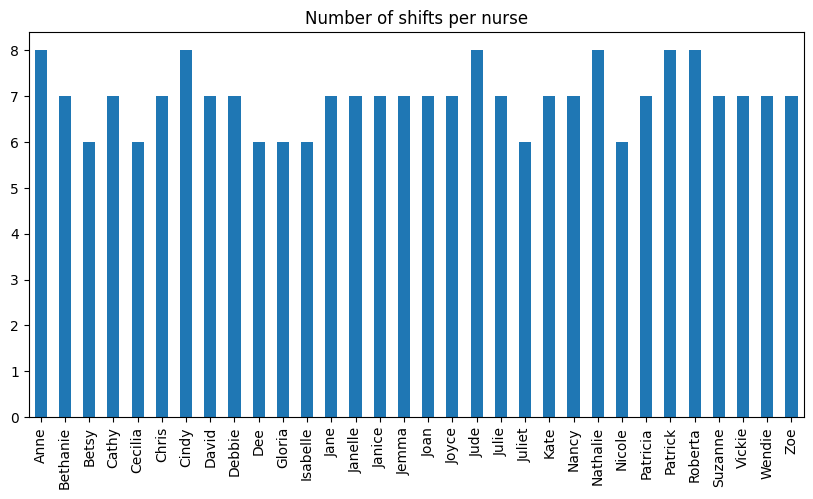

In [19]:
x.pivot().sum(axis=1).plot(
    kind="bar", title="Number of shifts per nurse", figsize=(10, 5)
)

To see how work time is distributed among nurses, plot a barchart of work time values.

<Axes: title={'center': 'Total working time per nurse'}, xlabel='n'>

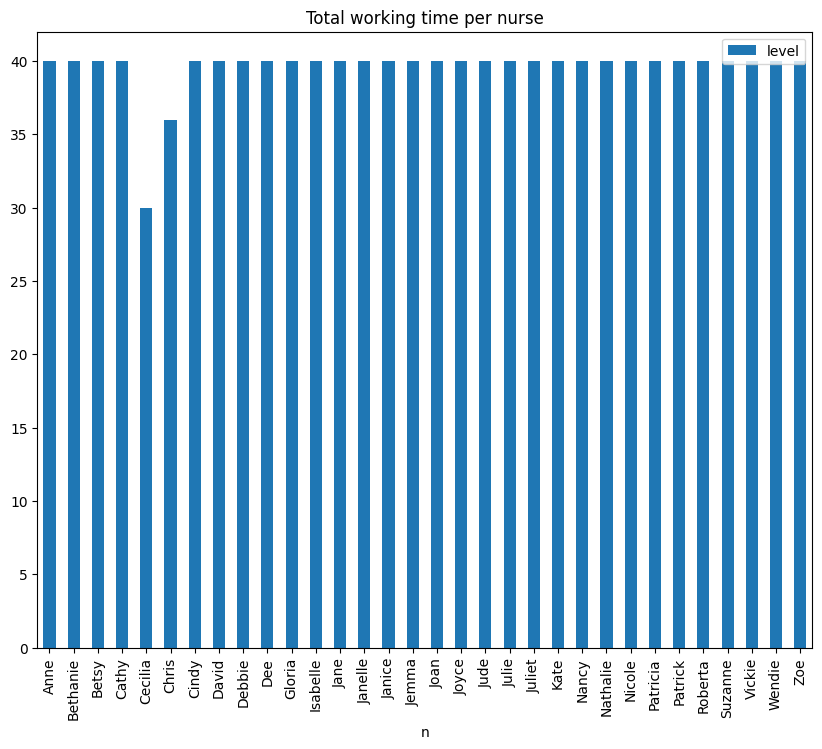

In [20]:
y.records[["n", "level"]].plot(
    kind="bar", x="n", y="level", title="Total working time per nurse", figsize=(10, 8)
)

We see that one nurse (Chris) works significantly fewer hours than others do. Therefore, the distribution of shifts could be improved.
We implement this by modifying the objective function to enforce balancing the shifts assigned over nurses.

Note that we can edit the model, that  is add (or remove) constraints, even after it has been solved. 

We add the following to our initial model:

### Parameters:

- $avgShifts$ ; Theoretical Average number of shifts per nurse -> Shifts required / #nurses

### Decision Variables:

- $worked_n$ ; Amount of shifts worked by nurse $n$ where $worked_n \ge 0$   $\forall n$
- $overworked_n$ ; Overworked shifts by nurse $n$ where $worked_n \ge 0$   $\forall n$
- $underworked_n$ ; Underworked shifts by nurse $n$ where $worked_n \ge 0$   $\forall n$

### Constraints:

- workedCons ${n}$: $worked_n = \sum_s(x_{n,s})$
- deviation ${n}$: $worked_n = avgShifts + overworked_n - underworked_n$
- newObj: Minimize $salary + \sum_n(overworked_n) + \sum_n(underworked_n)$

In [21]:
avg_shifts = Parameter(
    m, name="avg_shifts", description="Theoretical Average number of shifts per nurse"
)


avg_shifts[...] = Sum(s, req[s]) / len(nurses_names)

In [22]:
worked = Variable(
    m,
    name="worked",
    domain=n,
    type="positive",
    description="Amount of shifts worked by each nurse",
)


overworked = Variable(
    m,
    name="overworked",
    domain=n,
    type="positive",
    description="Overworked shifts by each nurse",
)


underworked = Variable(
    m,
    name="underworked",
    domain=n,
    type="positive",
    description="Underworked shifts by each nurse",
)

In [23]:
# Equations
worked_eq = Equation(
    m,
    name="worked_eq",
    domain=n,
    description="Define the amount of shifts worked by each nurse",
)
deviation = Equation(
    m,
    name="deviation",
    domain=n,
    description="Define the deviation of each nurse from the average",
)

In [24]:
worked_eq[n] = worked[n] == Sum(s, x[n, s])
deviation[n] = worked[n] == avg_shifts + overworked[n] - underworked[n]

new_obj = salary + Sum(n, overworked[n]) + Sum(n, underworked[n])

In [25]:
nurses2 = Model(
    m,
    name="nurses2",
    problem="MIP",
    equations=m.getEquations(),
    sense="Min",
    objective=new_obj,
)

In [26]:
nurses2.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,29509.9375,1708,1474,MIP,CPLEX,0.218


In [27]:
sd_shifts2 = x.pivot().sum(axis=1).std()
sd_hours2 = y.records[["n", "level"]].set_index(y.records["n"])["level"].std()

<Axes: title={'center': 'Number of shifts per nurse'}>

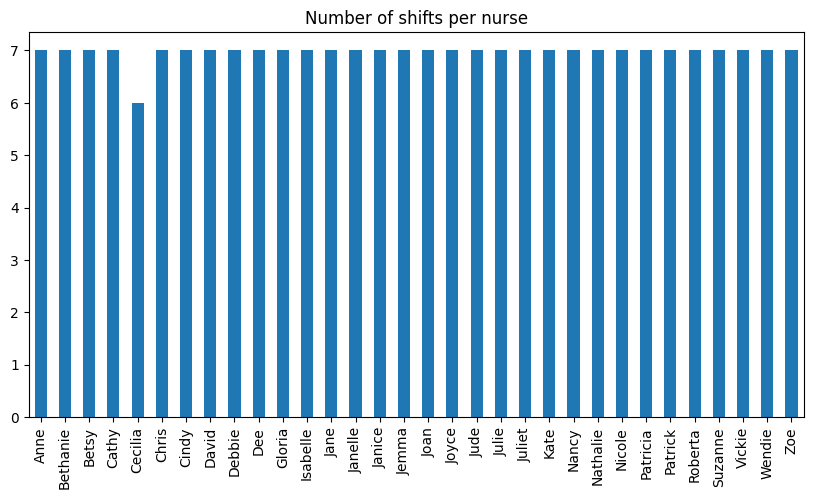

In [28]:
x.pivot().sum(axis=1).plot(
    kind="bar", title="Number of shifts per nurse", figsize=(10, 5)
)

<Axes: title={'center': 'Total working time per nurse'}, xlabel='n'>

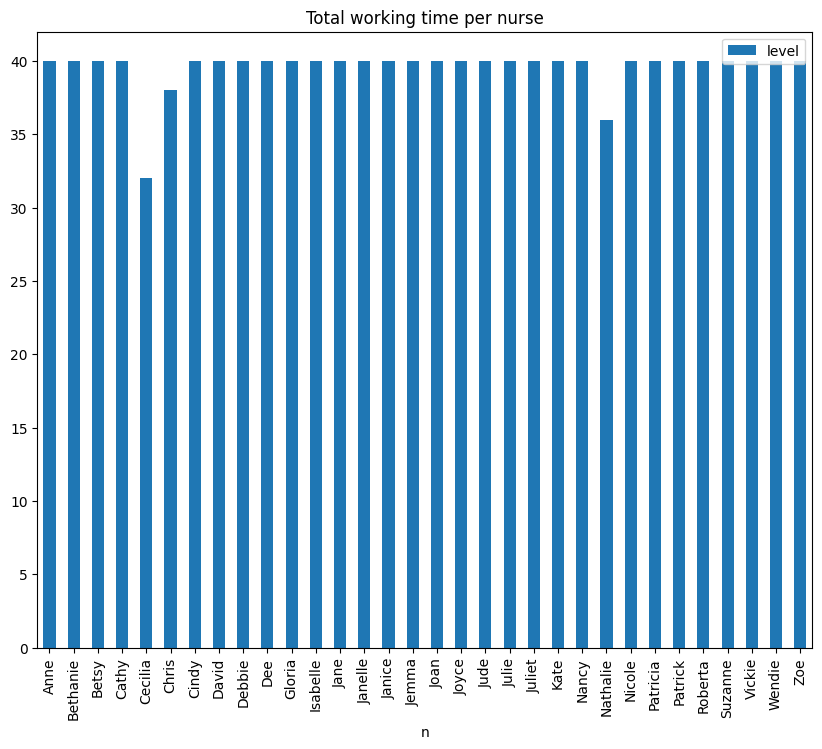

In [29]:
y.records[["n", "level"]].plot(
    kind="bar", x="n", y="level", title="Total working time per nurse", figsize=(10, 8)
)

The second model enforced fairness of assignment by introducing additional constraints and modifying the objective function. 

First, the model calculated the theoretical average number of shifts per nurse (`avg_shifts`) by dividing the total number of shifts required by the number of nurses. This value represents the ideal distribution of shifts among nurses.

Next, the model introduced three new decision variables: `worked`, `overworked`, and `underworked`. 

- `worked` represents the actual number of shifts worked by each nurse, calculated as the sum of assigned shifts (`x`) for each nurse.
- `overworked` represents the number of shifts that a nurse is assigned above the average number of shifts per nurse.
- `underworked` represents the number of shifts that a nurse is assigned below the average number of shifts per nurse.

The model then added two new equations to enforce fairness:
- The `worked_eq` equation ensures that the `worked` variable is equal to the sum of assigned shifts for each nurse.
- The `deviation` equation calculates the deviation of each nurse from the average number of shifts. It states that the `worked` variable should be equal to the `avg_shifts` plus the `overworked` variable minus the `underworked` variable.

Finally, the objective function was modified to minimize the total salaries spent (`salary`) while also considering the sum of `overworked` and `underworked` shifts. This ensures that the model not only minimizes costs but also balances the distribution of shifts among nurses.

By introducing these constraints and modifying the objective function, the second model enforced fairness in the assignment of shifts. This can be observed in the plots generated after solving the model. The first plot shows the number of shifts per nurse, indicating a more balanced distribution compared to the initial model. The second plot displays the total working time per nurse, reflecting a more equitable allocation of shifts among nurses.

In [30]:
# Display the results
report = Parameter(m, name="report", domain=["*", "*"], description="Result summary")
report["Model1", "Total Salaries"] = nurses.objective_value
report["Model1", "sd of # shifts"] = sd_shifts1
report["Model1", "sd of # hours"] = sd_hours1
report["Model2", "Total Salaries"] = salary.toValue()
report["Model2", "sd of # shifts"] = sd_shifts2
report["Model2", "sd of # hours"] = sd_hours2

print("\nResults summary:")
print(report.pivot())


Results summary:
        Total Salaries  sd of # shifts  sd of # hours
Model1         29508.0        0.646797       1.882646
Model2         29508.0        0.176777       1.584960
